(content:references:tabular_part1)=
# Grids of Stellar Models Part 1: *Stellar Parameter Regression*

***Author: Marc Hon***

In this chapter, we will explore the use of machine learning to determine the properties of stars from numerical data extracted from stellar observations.

## Grids of Evolutionary Tracks/Isochrones

Upon obtaining the properties of an astronomical object from observations -- be it raw measurements or more refined calculations -- the next step in learning further about the observed object
is to connect observations to theory. This often involves comparing these observed quantities with those from theoretical simulations, computed either analytically or numerically. 

For stars, comparisons between theory and observations are commonly performed using grids of **evolutionary tracks** and **isochrones**.

```{figure} images/track_iso.png
---
height: 450px
width: 800px
name: evol_tracks
---
Grids of stellar models presented in effective/surface temperature ($T_{\mathrm{eff}}$) and bolometric luminosity ($L$). (*Left*) Evolutionary tracks from [Maeder A., Meynet G., (1989)](https://ui.adsabs.harvard.edu/abs/1989A%26A...210..155M/abstract) (*Right*) Isochrones from the [Padova stellar evolution code](https://github.com/astroChasqui/astro101_graphs).
```

Evolutionary track and isochrones are model-generated sequences that describe stellar properties over time, but they differ in what is held constant:

- An evolutionary track traces the life of a single star of fixed mass, showing how its properties evolve.
- An isochrone connects models of stars that all share the same age but differ in mass, representing a snapshot in time across different evolutionary stages.

Each model along a track or isochrone provides a set of stellar properties, which we can broadly divide into two categories:

- **Output Observables**: These are predicted properties of the model that can be directly compared to telescope observations. Examples of these are  $T_{\mathrm{eff}}$, metallicity [Fe/H], and apparent magnitudes.
- **Input Parameters**: These are underlying properties or initial conditions of the model that may only be inferred from model fitting. Examples are stellar ages and initial helium ($Y$) and metal ($Z$) abundances. 

By finding the Input Parameters whose Output Observables match the observables from data, we may learn about the intrinsic properties of stars -- such as their ages, compositions, and evolutionary states.



In this Exercise, we are going to investigate this task on a grid of stellar models having photometric, spectroscopic, and asteroseismic observables from [Bellinger et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...830...31B/abstract).


In [82]:
import os
import yaml
import corner
import scienceplots
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import astropy.constants as const

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy import coordinates as coords
from scipy.stats import truncnorm, norm

plt.style.use('science'); fs=15

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter3' / 'data'

In [23]:
sim_df = pd.read_csv(str(data_folder_path) + '/simulations.csv')
sim_df

,M,Y,Z,alpha,overshoot,diffusion,age,radius,L,log_g,Teff,Fe/H,Dnu0,dnu02,r02,X_c
0,0.700137,0.236000,0.000323,1.726654,0.002538,19.077329,0.000000,0.590223,0.325432,4.741384,5680.219262,-1.734798,248.486628,19.935655,0.080239,0.763127
1,0.700137,0.236000,0.000323,1.726654,0.002538,19.077329,3.067329,0.675168,0.400312,4.624592,5593.088762,-2.162580,203.515485,14.853297,0.072778,0.521957
2,0.700137,0.236000,0.000323,1.726654,0.002538,19.077329,6.168685,0.764955,0.535708,4.516143,5651.606420,-2.533137,169.508823,8.951604,0.052694,0.272175
3,0.700137,0.236000,0.000323,1.726654,0.002538,19.077329,10.172691,0.979607,0.927548,4.301312,5728.833358,-2.927997,117.043200,4.808962,0.040707,0.036894
4,0.700192,0.331998,0.000032,1.836090,0.036713,0.000811,2.100065,0.649650,0.650736,4.658091,6438.274905,-2.680063,211.186402,17.229291,0.081523,0.518313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13659,1.599313,0.302350,0.008052,2.397614,0.193854,0.037411,0.253083,1.383068,11.387258,4.360479,9024.872970,-2.011042,92.109718,10.484210,0.113756,0.600678
13660,1.599313,0.302350,0.008052,2.397614,0.193854,0.037411,0.741981,1.697078,13.702543,4.182762,8533.111302,-4.391204,69.449754,6.354993,0.091851,0.381710
13661,1.599698,0.311761,0.003126,2.324799,0.000000,0.000307,0.092690,1.170153,14.413447,4.505785,10407.075842,-0.708765,114.582085,13.832250,0.123651,0.638902
13662,1.599698,0.311761,0.003126,2.324799,0.000000,0.000307,0.449779,1.364450,17.325731,4.372355,10091.415115,-0.705940,90.484944,9.093502,0.101327,0.422676


### Input Parameters, $\mathbf{y}$

| **Column**     | **Description**                                                                 |
|----------------|----------------------------------------------------------------------------------|
| `M`            | Initial stellar mass (in solar masses, $M_\odot$)                                |
| `Y`            | Initial helium mass fraction                                                    |
| `Z`            | Initial metallicity (mass fraction of elements heavier than helium)             |
| `alpha`        | Mixing-length parameter for convection, $\alpha$ (dimensionless)                          |
| `overshoot`    | Extent of convective overshooting beyond the core (in pressure scale heights)   |
| `diffusion`    | Efficiency parameter for microscopic diffusion (dimensionless or flag)          |
| `age`          | Stellar age (in Gyr)                                                             |
| `radius`       | Stellar radius (in solar radii, $R_\odot$)                                       |

In [24]:
sim_df['log_Z'] = np.log10(sim_df.Z.values)
sim_df['log_overshoot'] = np.log10(sim_df.overshoot.values + 1e-6)
sim_df['log_diffusion'] = np.log10(sim_df.diffusion.values + 1e-6)

```{note}
`overshoot` and `diffusion` parameters are customarily set to `0` to indicate that such settings are turned off in particular models, i.e., the models have no convective overshooting and/or microsopic diffusion. Because these values are distributed logarithmically otherwise, adding a small offset such as `1e-6` mitigates issues with visualizing the logarithm of their distributions.

```

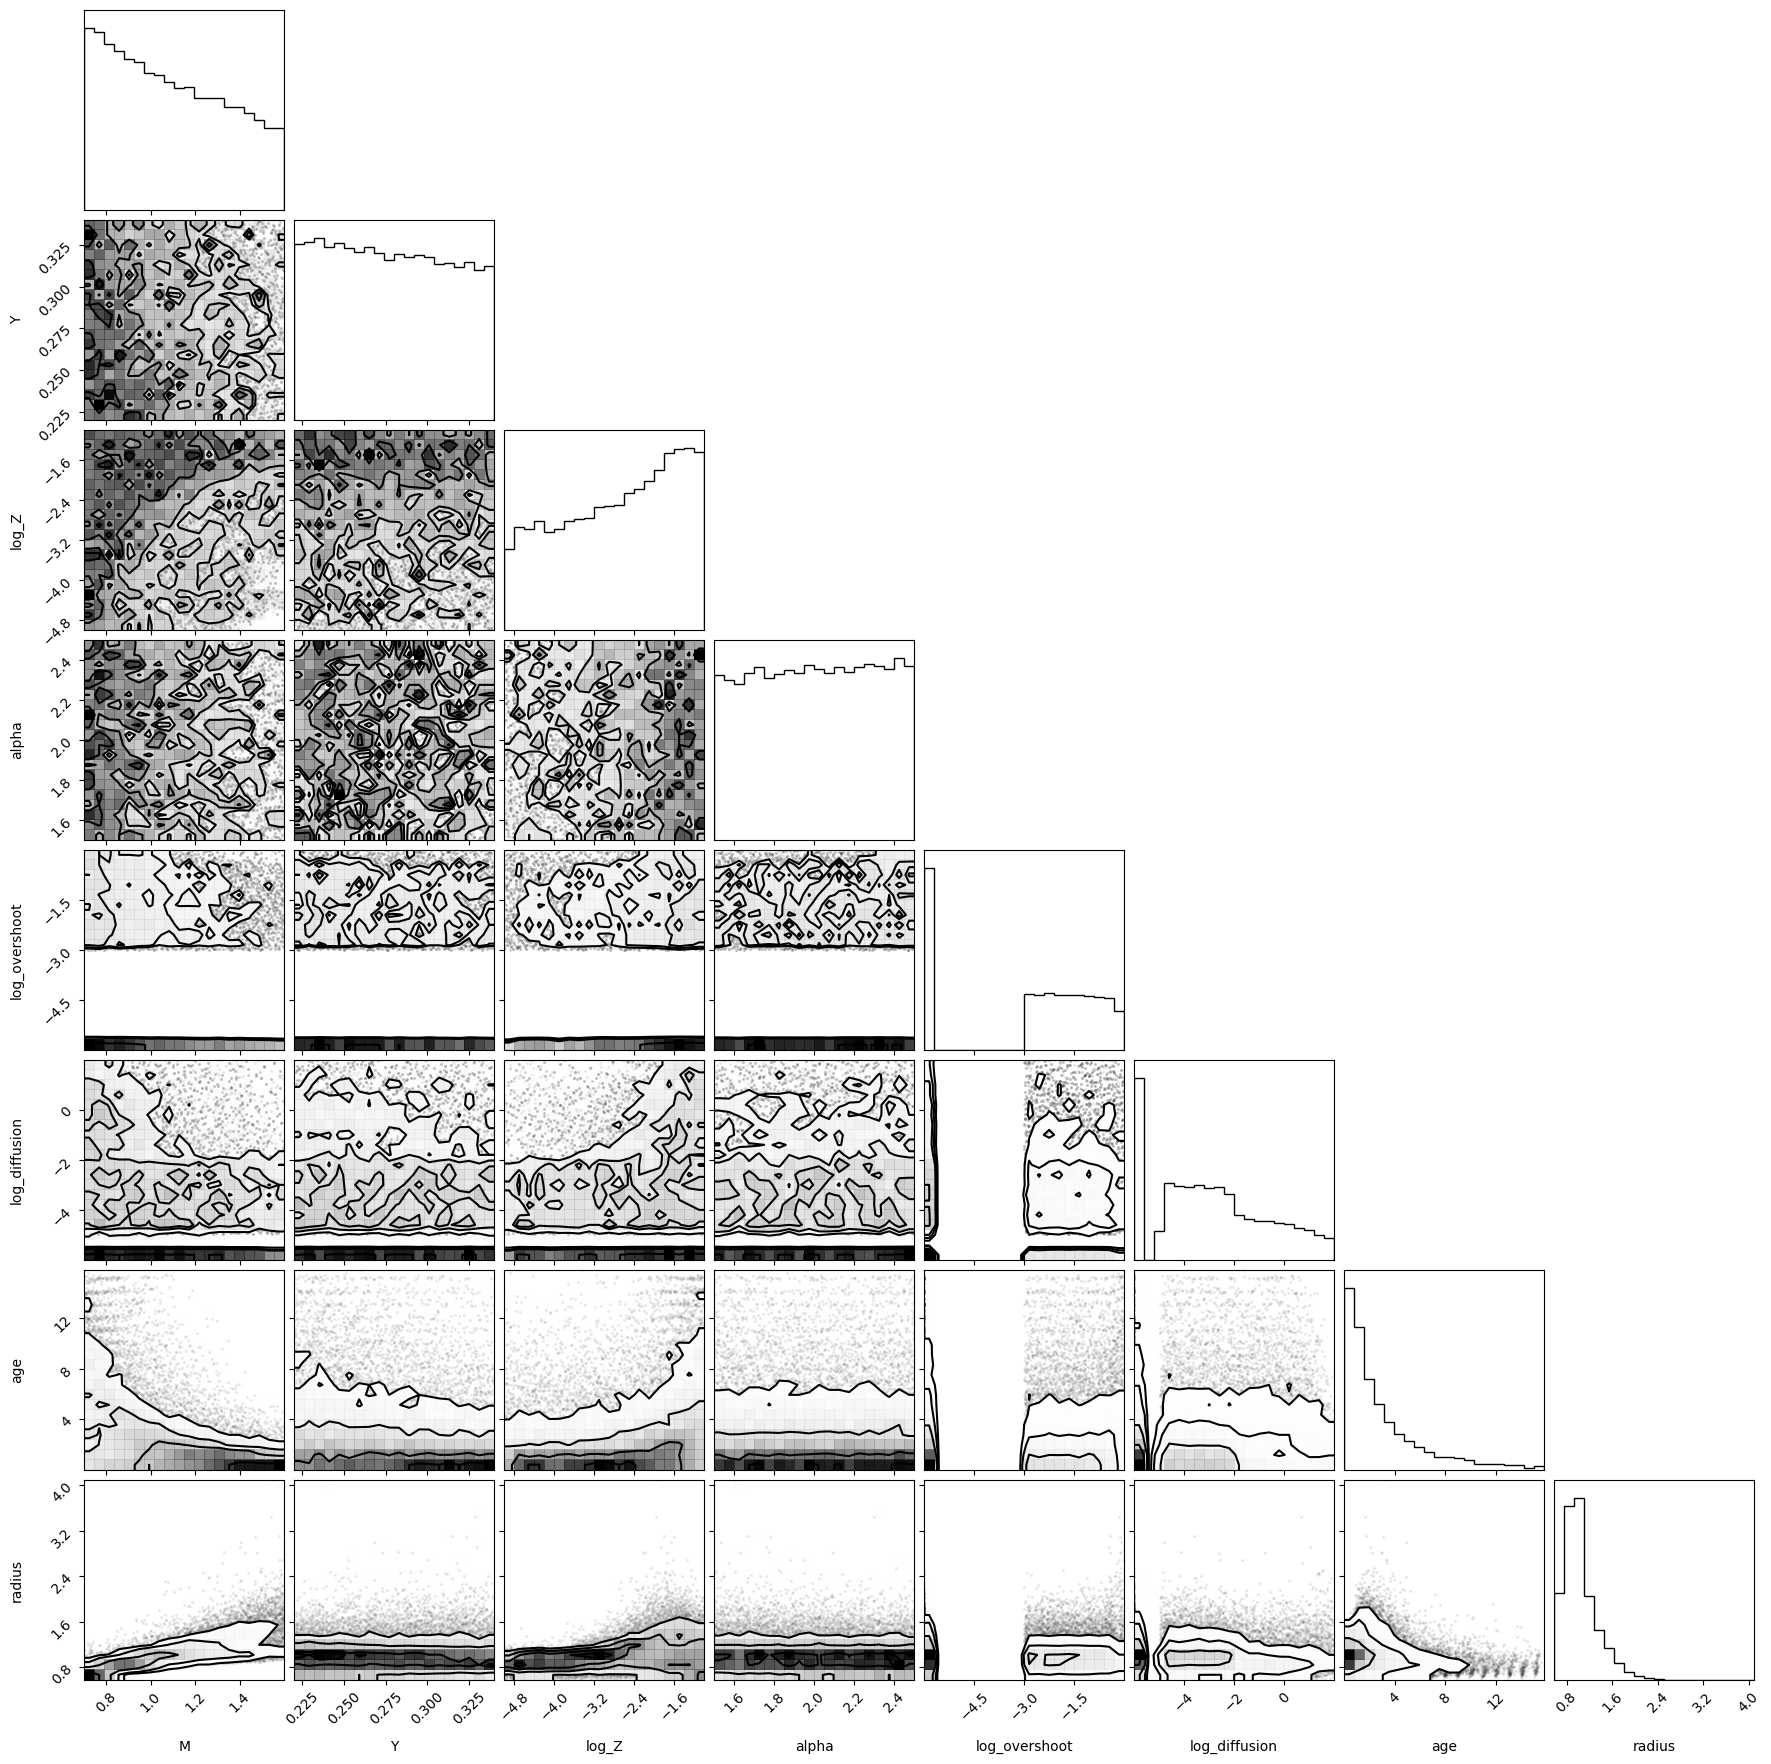

In [25]:
labels = ['M', 'Y', 'log_Z', 'alpha', 'log_overshoot', 'log_diffusion', 'age', 'radius']

fig = corner.corner(sim_df[labels], labels = np.array(labels))
plt.show()

### Observables, $\mathbf{x}$

| **Column**     | **Description**                                                                 |
|----------------|----------------------------------------------------------------------------------|
| `L`            | Stellar luminosity (in solar luminosities, $L_\odot$)                            |
| `log_g`        | Surface gravity (logarithmic, in cgs units)                                     |
| `Teff`         | Effective temperature (in Kelvin)                                                |
| `Fe/H`         | Surface iron abundance relative to solar ($[\mathrm{Fe}/\mathrm{H}]$)            |
| `Dnu0`         | Large frequency separation of radial modes ($\mu$Hz), linked to mean density     |
| `dnu02`        | Small frequency separation between $\ell = 0$ and $\ell = 2$ modes ($\mu$Hz)     |
| `r02`          | Frequency ratio: $r_{02} = \frac{\nu_{n,0} - \nu_{n-1,2}}{\nu_{n,1} - \nu_{n-1,1}}$, sensitive to core structure |
| `X_c`          | Central hydrogen mass fraction, indicating evolutionary state                   |


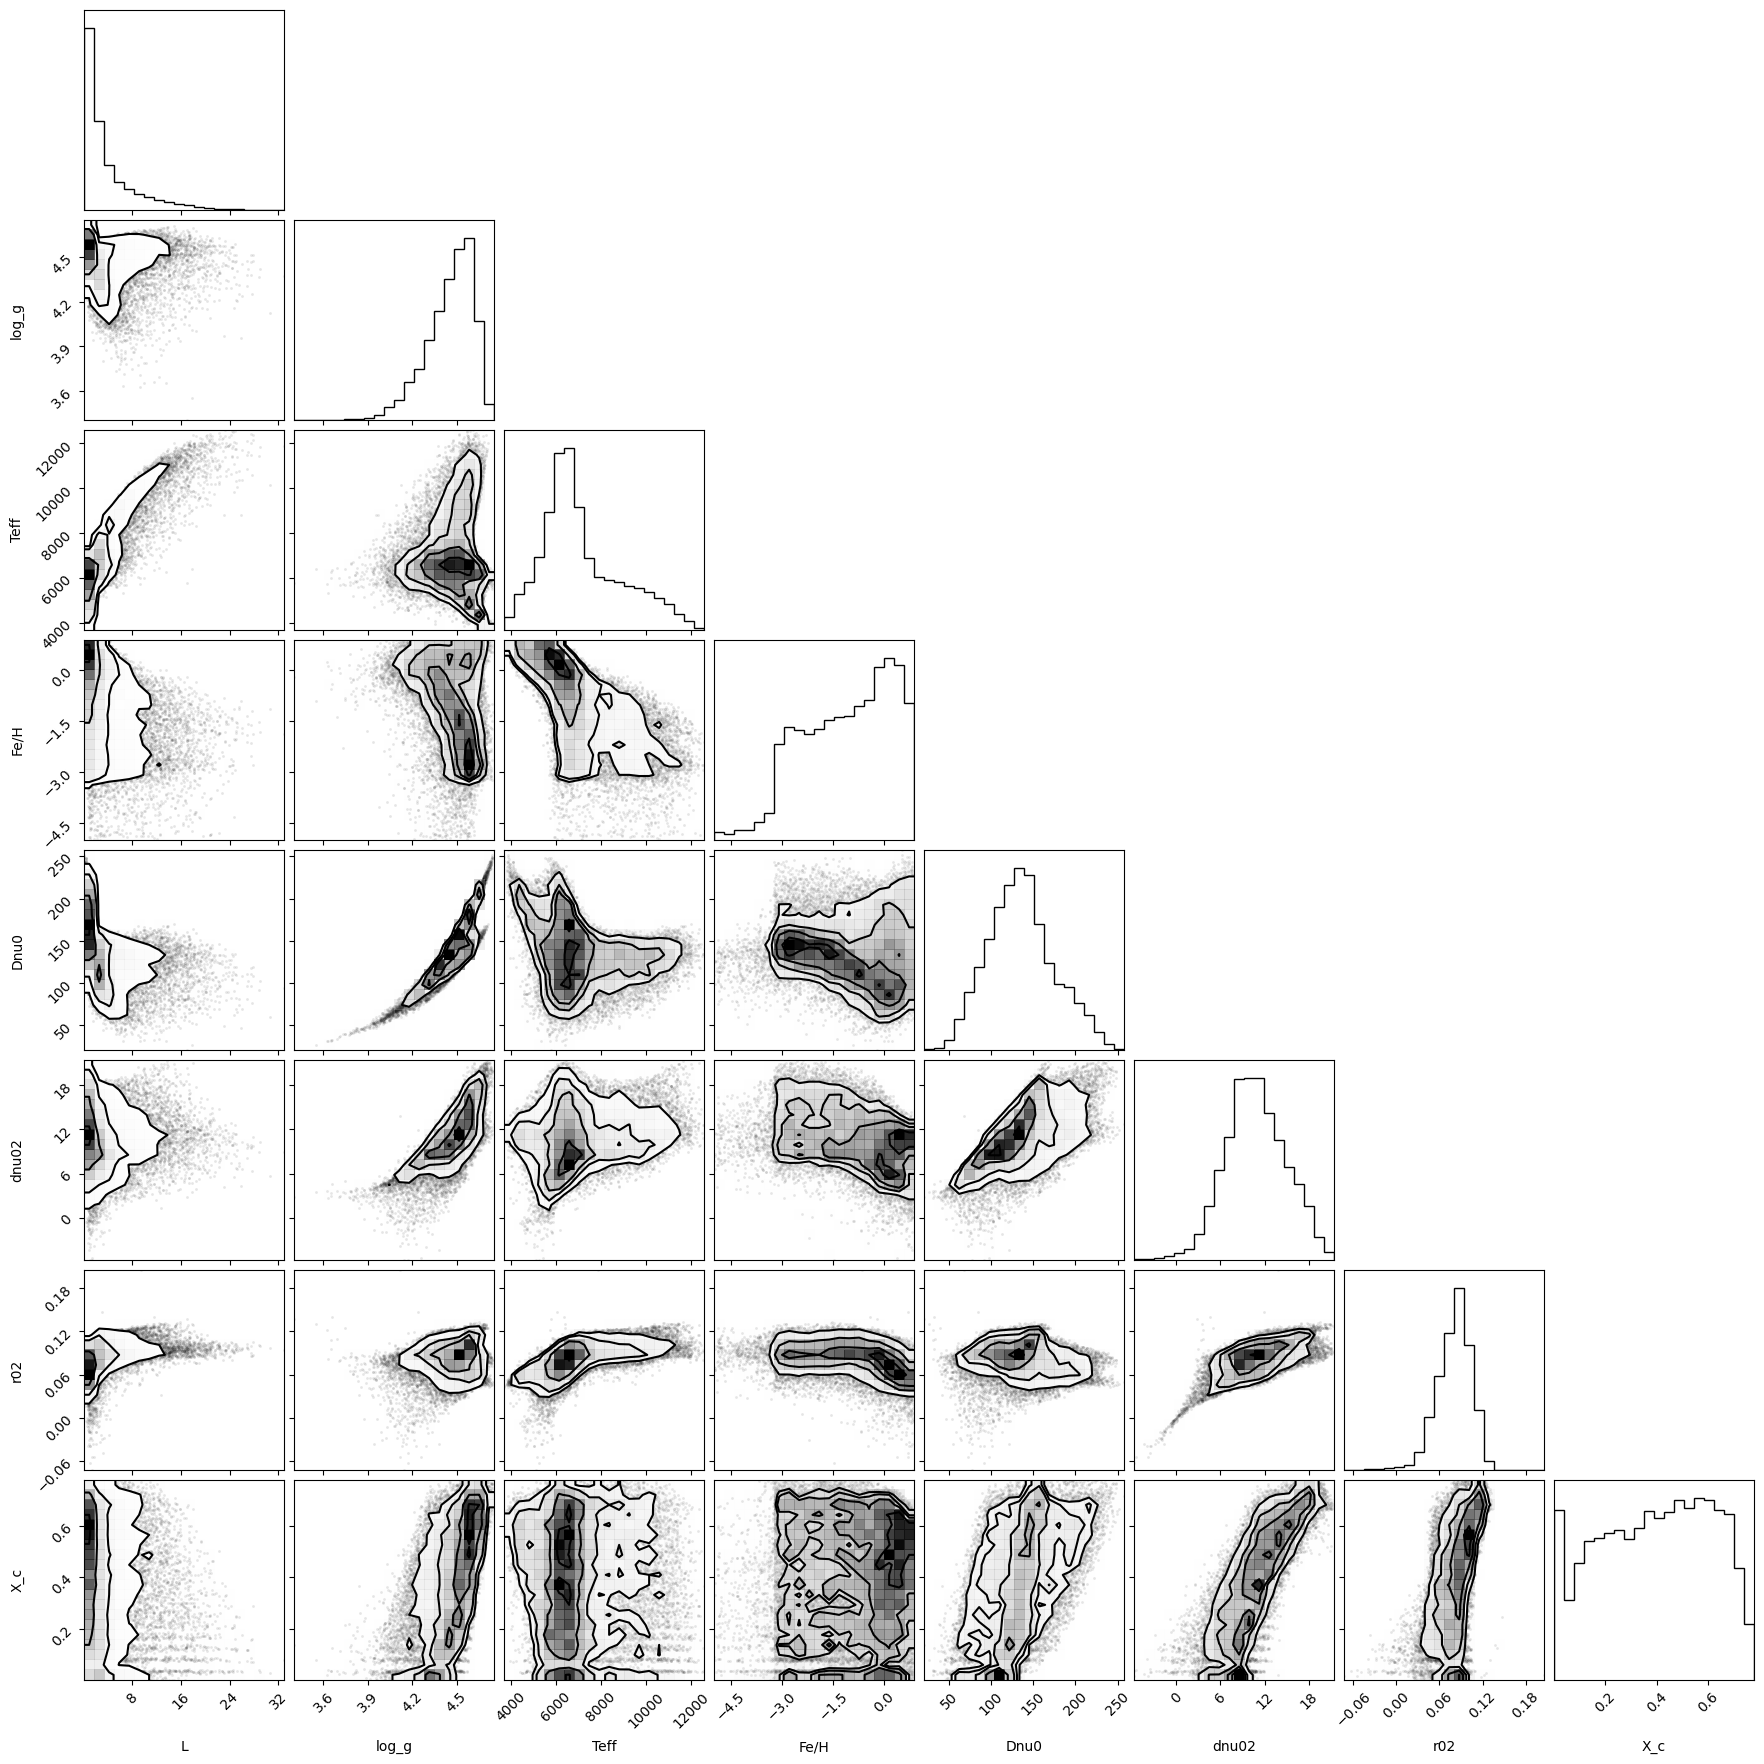

In [26]:
labels = ['L', 'log_g', 'Teff', 'Fe/H', 'Dnu0', 'dnu02', 'r02', 'X_c']

fig = corner.corner(sim_df[labels], labels = np.array(labels))
plt.show()

## Regression on a Grid of Stellar Models

The key task in stellar modeling is the following:

 > Given a set of output observables $\mathbf{x}$ from data, determine the model input parameters $\mathbf{y}$ that produce observables most consistent with $\mathbf{x}$.
 
This amounts to identifying the model that best explains the data from the grid. The simplest way of attempting this would be to treat the grid of models as a **look-up table**.

### Nearest Neighbours Look-Up

For this exercise, let's apply `scikit-learn`'s `NearestNeighbors` module, which uses a Euclidean distance metric to measure the proximity of input data to the grid of models. First, let us pre-process the grid of models as a training set.

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Observables (features)
X = sim_df[['L', 'log_g', 'Teff', 'Fe/H', 'Dnu0', 'dnu02', 'r02']].values

# Target physical parameters (labels)
y_ = sim_df[['M', 'Y', 'Z', 'alpha', 'overshoot', 'diffusion', 'age', 'radius']]
y = y_.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler() # standard scaling the observables
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

`````{admonition} Standard scaling for nearest neighbors lookup
:class: important
Is the application of feature scaling for `X` important to correctly find the nearest neighbour model from the grid?
`````

In [57]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train)

nn_distances, indices = nn.kneighbors(X_test)
y_pred_nn = y_train[indices.flatten()] 

Here `indices` corresponds to the indices of the closest matching model in the grid (`y_train`). We have effectively assigned actual models in the grid as predictions. Let's observe its predictive power.

In [98]:
from sklearn.metrics import mean_absolute_error, r2_score

mae_nn = mean_absolute_error(y_test, y_pred_nn, multioutput='raw_values')
r2_nn = r2_score(y_test, y_pred_nn, multioutput='raw_values')

for param, err, rr in zip(y_.columns, mae_nn, r2_nn):
    print(f"MAE for {param}: {err:.4f} \t R2: {rr:.4f}") 

MAE for M: 0.0592 	 R2: 0.9069
MAE for Y: 0.0324 	 R2: -0.3895
MAE for Z: 0.0027 	 R2: 0.9247
MAE for alpha: 0.2794 	 R2: -0.4995
MAE for overshoot: 0.1197 	 R2: -0.4339
MAE for diffusion: 2.9787 	 R2: -0.0368
MAE for age: 0.5594 	 R2: 0.8567
MAE for radius: 0.0285 	 R2: 0.9804


```{admonition} Understanding the R² Score
:class: tip

The **R² score**, also known as the *coefficient of determination*, is a common metric used to evaluate regression models. It provides a measure of how well the model’s predictions approximate the true data.

Mathematically, it is defined as:

$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
$$

Where:
- $ y_i $ are the true values,
- $ \hat{y}_i $ are the predicted values,
- $ \bar{y} $ is the mean of the true values.

### Key Interpretations:
- $ R^2 = 1 $: Perfect prediction — the model explains all variability in the data.
- $ R^2 = 0 $: The model performs no better than simply predicting the mean of the target variable.

Following the above definition, what would a **negative R²** indicate?

```

### Linear Regression

`y_pred_nn` uses no learning and merely does a retrieval. Let's observe a predictive performance using a global linear mapping:

$$
\mathbf{y} = \mathbf{X}\cdot \beta,
$$

where $\beta$ are linear regression coefficients.

In [100]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [101]:
mae_lr = mean_absolute_error(y_test, y_pred_lr, multioutput='raw_values')
r2_lr = r2_score(y_test, y_pred_lr, multioutput='raw_values')

for param, err, rr in zip(y_.columns, mae_lr, r2_lr):
    print(f"MAE for {param}: {err:.4f} \t R2: {rr:.4f}") 

MAE for M: 0.0765 	 R2: 0.8532
MAE for Y: 0.0269 	 R2: 0.1331
MAE for Z: 0.0097 	 R2: 0.6648
MAE for alpha: 0.2421 	 R2: 0.0299
MAE for overshoot: 0.1151 	 R2: 0.0533
MAE for diffusion: 4.5010 	 R2: 0.1438
MAE for age: 1.1610 	 R2: 0.7034
MAE for radius: 0.0537 	 R2: 0.9449


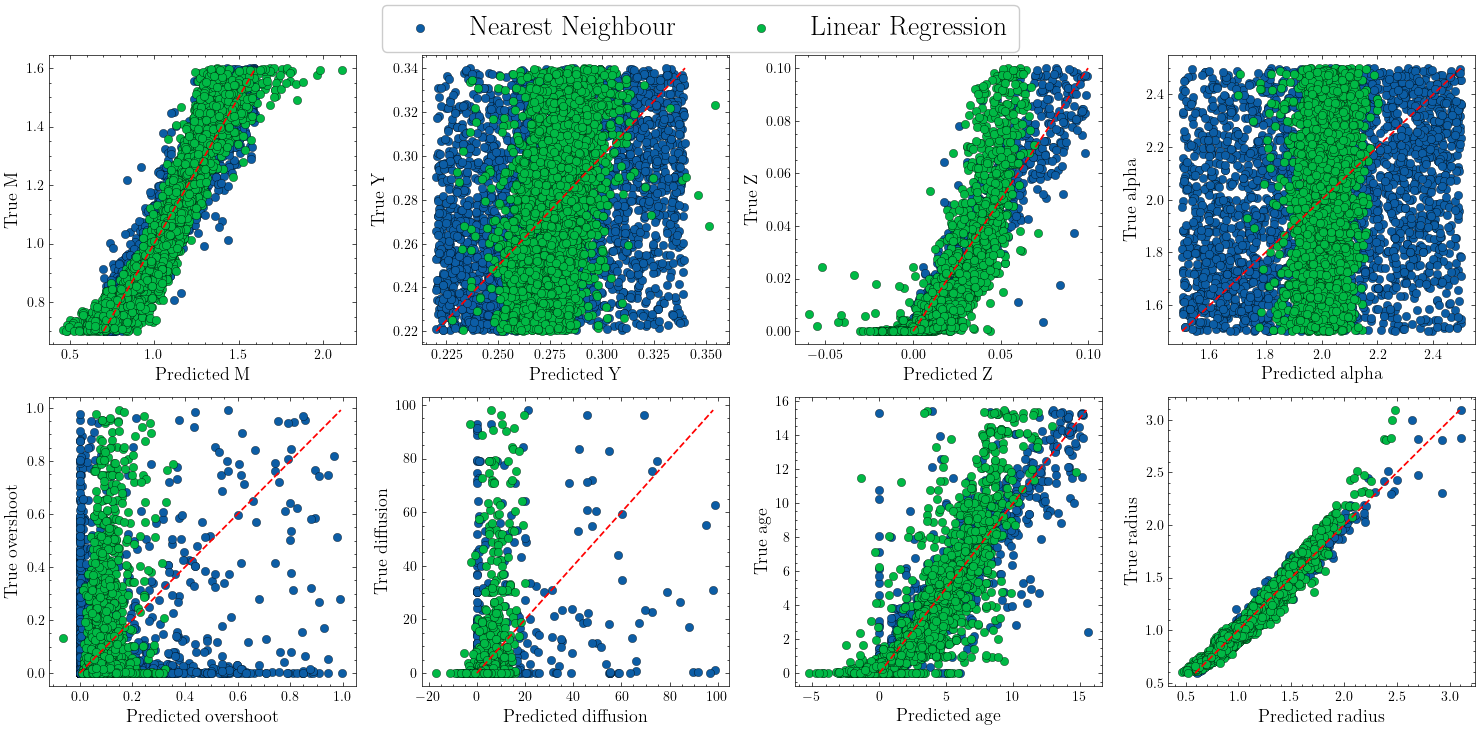

In [111]:
fig = plt.figure(figsize=(15,7))
for i in range(8): 
    ax = fig.add_subplot(2,4,i+1)
    if i == 7:
        label_nn = 'Nearest Neighbour'
        label_lr = 'Linear Regression'
    else:
        label_nn = label_lr = None
    ax.scatter(y_pred_nn[:,i], y_test[:,i], edgecolor='k', lw=0.25, label=label_nn)
    ax.scatter(y_pred_lr[:,i], y_test[:,i], edgecolor='k', lw=0.25, label=label_lr)
    ax.plot([min(y_test[:,i]), max(y_test[:,i])], [min(y_test[:,i]), max(y_test[:,i])], c='r', ls='--', lw=1.25)
    ax.set_xlabel(f'Predicted {y_.columns[i]}', fontsize=fs-2)
    ax.set_ylabel(f'True {y_.columns[i]}', fontsize=fs-2)

fig.legend(bbox_to_anchor= (-0.105, 1.02, 0.8, 0.05), ncols=2, framealpha=1, frameon=1,
          prop={'size': fs+5}); plt.tight_layout(w_pad=1, h_pad=1); plt.show()

`````{admonition} Prediction behaviour and R² Score
:class: important
Explain the behaviour of the the $Y$ and $\alpha$ predictions from the linear regression and nearest neighbour models in relation to their R² scores. In particular,

- Why are the predicted values dispersed across the full parameter range for the nearest neighbour model?
- Why are the predicted values concentrated within a narrow band of values for the linear regression model?

`````

### Random Forest Regression

Given that the relationship between features and targets is non-linear or complex, we may use a more sophisticated model in the form of random forests to perform the regression task.

A Random Forest builds many decision trees, each trained on a random subset of the data. The regression prediction is the average of all individual tree outputs:

$$
\hat{y}_{\text{RF}}(\mathbf{x}) = \frac{1}{T} \sum_{t=1}^{T} \hat{y}_t(\mathbf{x})
$$

where:
- $ T $ is the total number of trees,
- $ \hat{y}_t(\mathbf{x}) $ is the prediction from the $ t $-th tree for input $ \mathbf{x} $.

Each decision tree splits the feature space into regions based on thresholds that minimize the loss (e.g., mean squared error (MSE), and at each leaf node, the predicted value is simply the mean of the training targets that fall into that region.



In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [99]:
from sklearn.metrics import mean_absolute_error

mae_rf = mean_absolute_error(y_test, y_pred_rf, multioutput='raw_values')
r2_rf = r2_score(y_test, y_pred_rf, multioutput='raw_values')

for param, err, rr in zip(y_.columns, mae_rf, r2_rf):
    print(f"MAE for {param}: {err:.4f}  \t R2: {rr:.4f}") 

MAE for M: 0.0491  	 R2: 0.9388
MAE for Y: 0.0266  	 R2: 0.1489
MAE for Z: 0.0024  	 R2: 0.9487
MAE for alpha: 0.2181  	 R2: 0.1643
MAE for overshoot: 0.1066  	 R2: 0.1739
MAE for diffusion: 2.4847  	 R2: 0.4773
MAE for age: 0.4423  	 R2: 0.9053
MAE for radius: 0.0267  	 R2: 0.9547


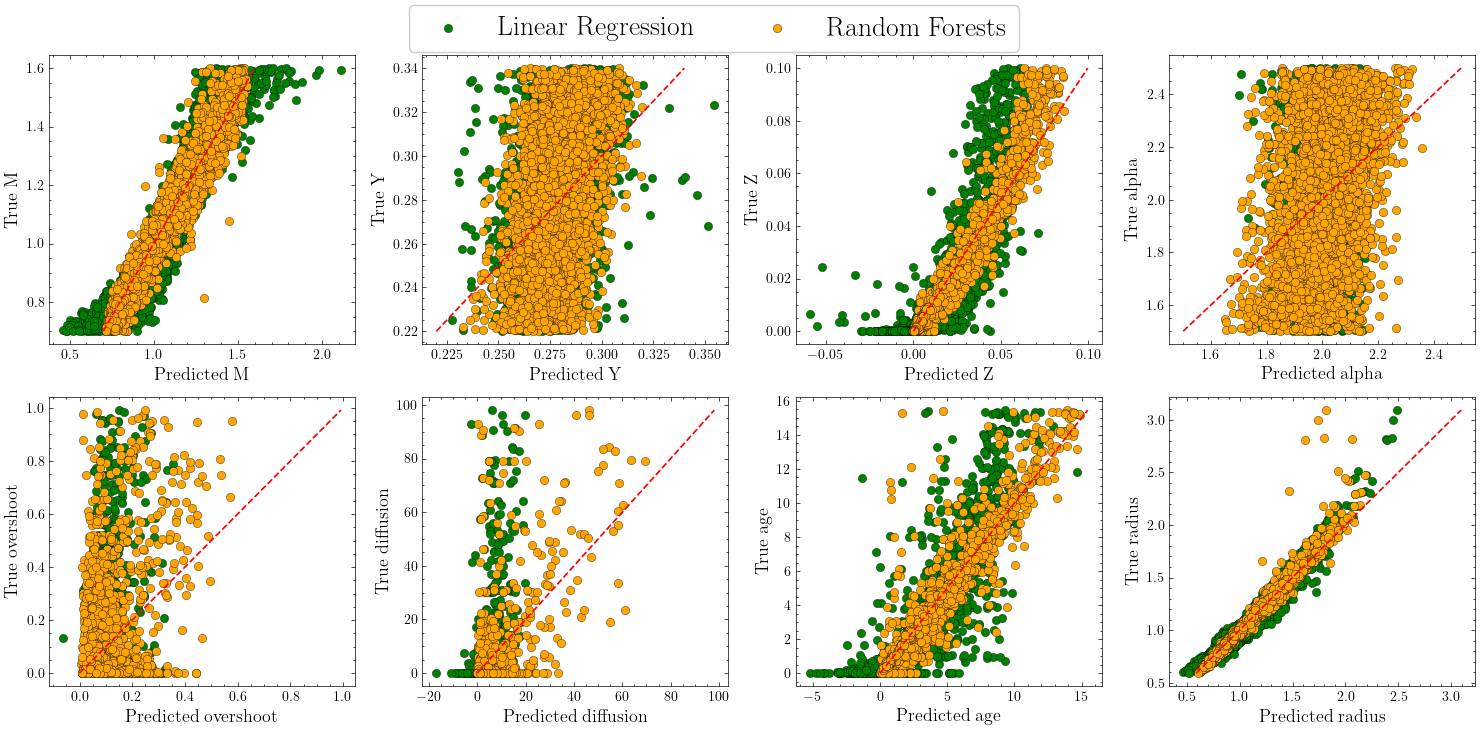

In [112]:
fig = plt.figure(figsize=(15,7))
for i in range(8): 
    ax = fig.add_subplot(2,4,i+1)
    if i == 7:
        label_lr = 'Linear Regression'
        label_rf = 'Random Forests'
    else:
        label_lr = label_rf = None
    ax.scatter(y_pred_lr[:,i], y_test[:,i], edgecolor='k', lw=0.25, label=label_lr, c='g')
    ax.scatter(y_pred_rf[:,i], y_test[:,i], edgecolor='k', lw=0.25, label=label_rf, c='orange')
    ax.plot([min(y_test[:,i]), max(y_test[:,i])], [min(y_test[:,i]), max(y_test[:,i])], c='r', ls='--', lw=1.25)
    ax.set_xlabel(f'Predicted {y_.columns[i]}', fontsize=fs-2)
    ax.set_ylabel(f'True {y_.columns[i]}', fontsize=fs-2)

fig.legend(bbox_to_anchor= (-0.105, 1.02, 0.8, 0.05), ncols=2, framealpha=1, frameon=1,
          prop={'size': fs+5}); plt.tight_layout(w_pad=1, h_pad=1); plt.show()

The use of an algorithm that is capable of dealing with non-linear relationships in the data evidently better suited for predicting relationships involved in stellar evolution!

## Feature Importances

In machine learning regression tasks, not all input features contribute equally to predicting the outputs. Some features may be highly informative for a given target variable, while others may be only weakly correlated or even irrelevant.

Understanding feature importances helps us interpret the behaviour of the machine learning algorithm, identify redundancies in the input space, and potentially improve predictive performance through feature selection.

In [122]:
from sklearn.multioutput import MultiOutputRegressor

## To view the RF importance for EACH parameter, we need to wrap the RF in scikit-learn's MultiOutputRegressor
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))

In [150]:
def compare_importances(idx):
    fig = plt.figure(figsize=(10, 5))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    ax1.barh(sim_df[['L', 'log_g', 'Teff', 'Fe/H', 'Dnu0', 'dnu02', 'r02']].columns, importances_lr)
    ax2.barh(sim_df[['L', 'log_g', 'Teff', 'Fe/H', 'Dnu0', 'dnu02', 'r02']].columns,
             importances_rf, color='orange')
    ax1.set_xlabel("Feature importance"); ax2.set_xlabel("Feature importance")
    ax2.set_yticklabels([])
    ax2.set_title(f"Random Forest Feature Importance")
    ax1.set_title(f"Linear Regression Feature Importance")
    [ax.text(x=0.8, y=0.8, s=f'Importance For\n{y_.columns[idx]}', transform=ax.transAxes,
            fontsize=fs, ha='center') for ax in [ax1, ax2]]
    plt.tight_layout(w_pad=0.02)

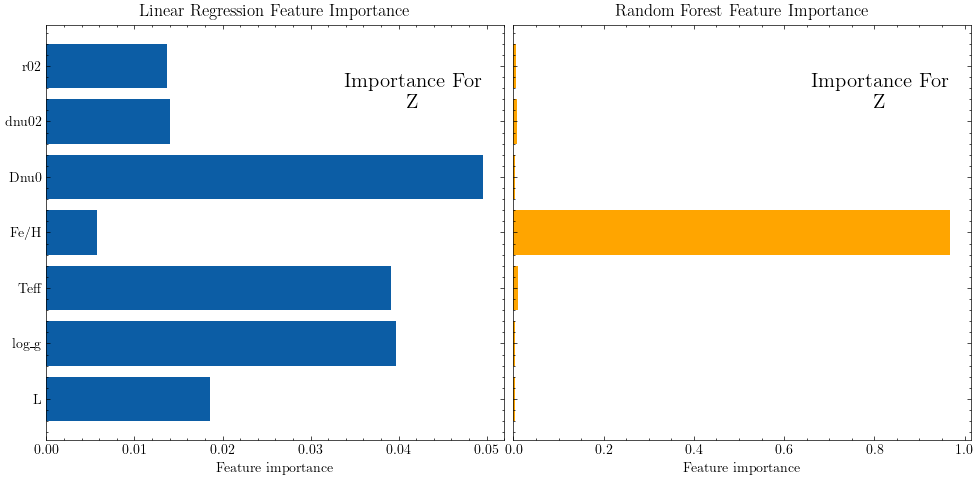

In [156]:
idx = 2
importances_rf = multi_rf.estimators_[idx].feature_importances_
importances_lr = np.abs(lr.coef_)[idx]

compare_importances(idx)

Do the feature importances make sense? It seems to be the case for random forests: the importance for mass (`idx = 0`) agrees with expectations of a [mass-luminosity relation](https://en.wikipedia.org/wiki/Mass%E2%80%93luminosity_relation) for main-sequence stars, which are those used in our grid of models. Meanwhile, the importance for $Z$ is heavily skewed towards metallicity [Fe/H], which makes sense: surely a star that has a higher metallicity should have had a higher initial metal fraction than those with lower metallicities!

`````{note} 
Observe the differences in feature importances for parameters that can be predicted fairly accurately (e.g., $M$ and $Z$) versus those with low prediction accuracy (e.g., diffusion, $\alpha$).
`````
However, qualitatively, we will find that the relative importances for linear regression (LR) will consistently differ from those provided by random forests (RF). Why?

### Differences between LR and RF feature importances 

The linear regression feature importance relies on the magnitude of the linear coefficients $\mathbf{\beta}$. Larger coefficients indicate a feature has a larger influence on the output, but only **linearly**. 
Implicit for LR is the assumption that features are independent of one another, which thus **ignores non-linear relations**.

Random forests, on the other hand, determine feature importance is computed by calculating the **total decrease in prediction error or impurity** from each feature across all trees. Specifically:

1. Every time a feature is used to split a node, it contributes to reducing the impurity.

2. This contribution is weighted by the number of samples reaching the node.

3. The importance for each feature is summed over all trees in the forest, and then normalized.

Therefore, RF tells you how useful each feature is in reducing error **through any number of nonlinear paths**.

### Feature importance determined externally: SHAP

Recent external approaches have been developed to explain the output of any machine learning model by assigning each feature an importance value. One such example is **SHAP** [(SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/).
It is based on Shapley values from cooperative game theory. More specifically, each feature is treated like a "player" in a game that contributes to a prediction. SHAP computes how much each feature contributes to the prediction, averaged over **all possible combinations of feature presence/absence**.

Let's examine the use of SHAP over our existing algorithms.

 96%|=================== | 263/274 [00:14<00:00]       

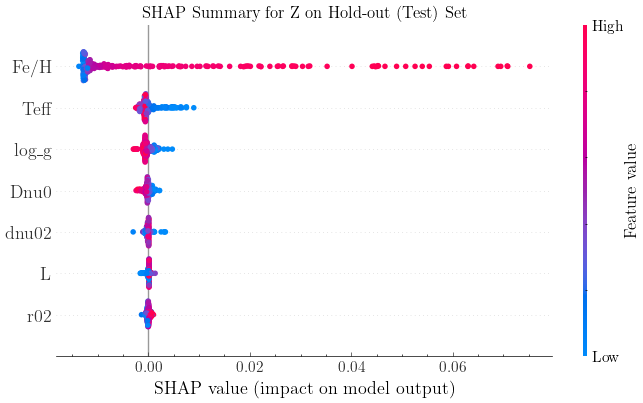

In [197]:
import shap

feat_names = ['L', 'log_g', 'Teff', 'Fe/H', 'Dnu0', 'dnu02', 'r02']

explainer = shap.Explainer(multi_rf.estimators_[idx], X_train,
                           feature_names= feat_names)
X_test_explain = X_test[::10]

shap_values = explainer(X_test_explain)
shap.plots.beeswarm(shap_values, show=False)
plt.title(f"SHAP Summary for {y_.columns[idx]} on Hold-out (Test) Set"); plt.show()

In the above, we are showing the SHAP values of features for a particular predicted parameter across the test set, where each point represents a test example. 

### Interpreting SHAP values

SHAP assigns each input feature an importance value for a particular prediction, reflecting how much that feature contributed (either positively or negatively) to the final model output:

$$
f(x) = \phi_0 + \sum_{i=1}^M \phi_i,
$$

- $f(x)$: the model's prediction for input $x$

- $\phi_0$ : the baseline prediction, i.e., the expected model output when no features are known, i.e., the mean over the training set

- $\phi_i$: the SHAP value for feature $i$, indicating its marginal contribution to this prediction


**Key Insight**

> The Shapley value is the average of all the marginal contributions to all possible combinations of features.


More concretely, assume our subset of features, $S$ is:

$$
S=[\log ⁡g,  \text{[Fe/H]},  \Delta\nu_0,  T_{\mathrm{eff}}],
$$

and we want to estimate the marginal contribution of $T_{\mathrm{eff}}$ to the model’s prediction for stellar age. SHAP performs the following:

1. Fix the known features ($\log ⁡g,  \text{[Fe/H]},  \Delta\nu_0$) to their values in the target star.

2. Sample multiple plausible values of $T_{\mathrm{eff}$ from the background grid of stellar models.

3. Use each sampled value of $T_{\mathrm{eff}$ together with the fixed values of the known features to evaluate the model's predicted age.

4. Average these predictions to estimate the expected prediction without $T_{\mathrm{eff}$, namely $\mathbb{E}[f(x) | $\log ⁡g,  \text{[Fe/H]},  \Delta\nu_0]$


The marginal contribution for $T_{\mathrm{eff}}$, $\phi_{T_{\mathrm{eff}}}$ is thus:

$$
\phi_{T_{\mathrm{eff}}} = \mathbb{E}[f(x) | \log ⁡g,  \text{[Fe/H]},  \Delta\nu_0, T_{\mathrm{eff}}]− \mathbb{E}[f(x) | \log ⁡g,  \text{[Fe/H]},  \Delta\nu_0].
$$


**The marginal contribution needs to be averaged across all feature permutations**, for instance:

- $[\log ⁡g,  \text{[Fe/H]},  \Delta\nu_0, T_{\mathrm{eff}}]$
- $[\text{[Fe/H]}, \log ⁡g,  \Delta\nu_0, T_{\mathrm{eff}}]$
- $[\text{[Fe/H]}, \Delta\nu_0, \log ⁡g,  T_{\mathrm{eff}}]$
- $[T_{\mathrm{eff}}, \log ⁡g,  \text{[Fe/H]},  \Delta\nu_0]$
...

and so on.

In [214]:
def shap_waterfall(shap_values, entry_idx, idx, feature_names=None, max_display=10):
    values = shap_values.values
    base_value = shap_values.base_values
    data = shap_values.data

    # Sort by absolute SHAP value (importance)
    idx_sorted = np.argsort(np.abs(values))[::-1][:max_display]
    values = values[idx_sorted]
    data = data[idx_sorted]
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(len(values))]
    else:
        feature_names = np.array(feature_names)[idx_sorted]

    # Compute cumulative contributions
    pred = base_value + np.sum(values)
    cumulative = [base_value]
    for v in values:
        cumulative.append(cumulative[-1] + v)
    cumulative = np.array(cumulative)

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, max(4, 0.4 * len(values))))

    # Bars
    for i in range(len(values)):
        color = 'green' if values[i] > 0 else 'red'
        ax.barh(i, values[i], left=cumulative[i], color=color, edgecolor='black')
        
    # Labels
    ax.set_yticks(np.arange(len(values)))
    ax.set_yticklabels([f"{name} = {val:.3f}" for name, val in zip(feature_names, data)])
    ax.axvline(base_value, color='gray', linestyle='--', label='Background prediction', lw=5)
    ax.axvline(pred, color='blue', linestyle='--', label='Prediction')
    ax.set_xlabel("Model output")
    ax.set_title(f"SHAP Waterfall Plot for {y_.columns[idx]}, Test Example {entry_idx}")
    ax.legend()
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

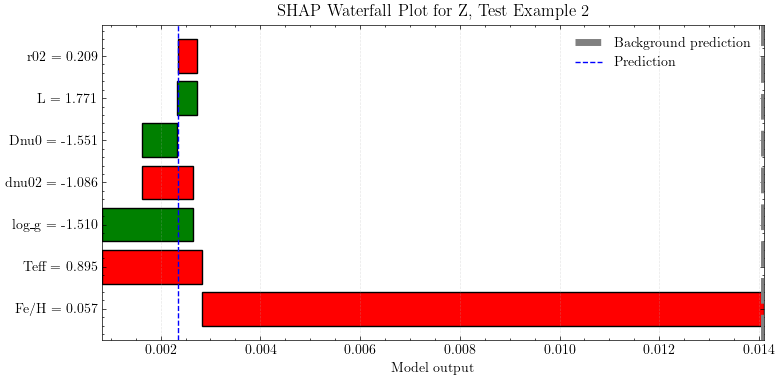

In [215]:
entry_idx = 2
shap_waterfall(shap_values[entry_idx], entry_idx, idx, feat_names)

`````{admonition} Reading the waterfall plot
:class: info

The features are sorted from bottom to top, most important first. Beginning at the background prediction, the most important feature increments (green) or decrements (red) the model output to a certain value. From this value, the next most important feature moves the model output based on its SHAP value. This proceeds until all features have been considered, arriving at the blue line. 

`````

We can verify that the sum of SHAP values for each feature is equal to the prediction:

In [229]:
print(f'Base Value: {shap_values[entry_idx].base_values:.5f}\n')

tot_shap = 0
for feat, val in zip(feat_names, shap_values[entry_idx].values):
    print(f'{feat} SHAP Value: {val:.5f}')
    tot_shap += val
    
print(f'\nBase Value + All SHAP Values: {(shap_values[entry_idx].base_values + tot_shap):.5f}')
print(f'Predicted Value: {multi_rf.estimators_[idx].predict(X_test_explain)[entry_idx]:.5f}')

Base Value: 0.01409

L SHAP Value: 0.00039
log_g SHAP Value: 0.00182
Teff SHAP Value: -0.00199
Fe/H SHAP Value: -0.01127
Dnu0 SHAP Value: 0.00070
dnu02 SHAP Value: -0.00102
r02 SHAP Value: -0.00037

Base Value + All SHAP Values: 0.00236
Predicted Value: 0.00236


`````{admonition}  Exercise: Leave One Feature Out (LOFO) Importance
:class: important

A simple approach for calculating the importance for a feature is to retrain the algorithm without a particular feature and reassessing the resulting performance. 

1. Using the **grid lookup algorithm** (i.e., `NearestNeighbors`), calculate the LOFO importance for a particular predicted output variable. You may use the **mean absolute error (MAE)** or the **R² score** as your metric.  
   - How does the LOFO importance compare to the feature importances computed previously using **linear regression** and **random forests**?

2. Using LOFO on the **lookup-based model**, calculate the importances **for each feature in a specific test point**.  
   - How do these *local LOFO importances* compare with the **SHAP values** computed for the same prediction?

`````


## See also

[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/shapley.html)